# Dictionary Analysis

## 1. Setup
Install/import essential packages.

In [368]:
# If running on a clean environment, uncomment the pip lines.
%pip install -q scikit-learn matplotlib pandas numpy krippendorff


Note: you may need to restart the kernel to use updated packages.


In [369]:

import numpy as np
import pandas as pd

np.random.seed(123)


## Dictionary Basics

A **dictionary** is a rule‑based list of words/phrases mapping text to categories or scores.

### Classification dictionary

In [370]:
positive_words = {"good", "happy", "excellent", "great", "love"}
negative_words = {"bad", "sad", "terrible", "awful", "hate"}

def classify_sentiment(text):
    tokens = text.lower().split()
    pos_hits = sum(t in positive_words for t in tokens)
    neg_hits = sum(t in negative_words for t in tokens)
    if pos_hits > neg_hits:
        return "positive"
    elif neg_hits > pos_hits:
        return "negative"
    else:
        return "neutral"

texts = [
    "I love this product, it is excellent",
    "This was terrible and I hate it",
    "It was okay, not great but not bad"
]

[(t, classify_sentiment(t)) for t in texts]


[('I love this product, it is excellent', 'positive'),
 ('This was terrible and I hate it', 'negative'),
 ('It was okay, not great but not bad', 'neutral')]

### Regression dictionary (scoring)
- Return a **continuous score** capturing *intensity* of sentiment.

In [371]:
sentiment_dict = {
    "good": +1, "happy": +2, "excellent": +3, "great": +2, "love": +3,
    "bad": -1, "sad": -2, "terrible": -3, "awful": -3, "hate": -2
}

def sentiment_score(text):
    tokens = text.lower().split()
    return sum(sentiment_dict.get(t, 0) for t in tokens)

[(t, sentiment_score(t)) for t in texts]


[('I love this product, it is excellent', 6),
 ('This was terrible and I hate it', -5),
 ('It was okay, not great but not bad', 1)]

# Real Data

For this tasks, we will work with selected headlines from news articles about migration. The data set is a subset of the [REMINDER media corpus](https://doi.org/10.11587/IEGQ1B).

Let's load the data first and take a look. Each row represents one news article.

For our exercise, we work again with the English headlines (published in UK newspapers). 
Now, we load the data directly.


In [372]:
# Read the CSV file from the URL
articles_en = pd.read_csv("headlines.csv")


# Check corpus size
corpus_size = len(articles_en)
print(f'Corpus size: {corpus_size}')

# Display the dataset
print(articles_en.head())

# Display column names
print(articles_en.columns)

Corpus size: 500
   id country publication_date           source source_type  \
0   1      UK       2013-02-09     Daily Mirror       Print   
1   4      UK       2012-03-16  telegraph.co.uk      Online   
2   5      UK       2012-08-27  telegraph.co.uk      Online   
3   8      UK       2016-12-13     mirror.co.uk      Online   
4  11      UK       2016-03-03     The Guardian       Print   

                                                                                                                                                                                                                                                         headline  
0                                                                                                                                                                                                                              Asylum girl 'fed up' in UK;\nCOURT  
1                                                                        Archbishop 

## Automated Classification with a Dictionary

For this tutorial, we want to identify all articles that mention political actors in their headlines. The salience of 'Political actors' is the concept that we want to measure with a dictionary. As a first step, we define the concept more closely.

### Concept Definition

**Political actors** are here defined as political parties represented in the House of Commons between 2000 and 2017, which is the period in which the articles in our sample where published. Next to these parties, we define UK politicians with a leading role as political actors. To keep the task manageable for this exercise, we focus only on actors highly relevant between 2000 and 2017. 

We intend to measure the salience of political actors as simple binary variable:
1 = At least one political actor is mentioned
0 = No political actor is mentioned.

### Dictionary creation

A dictionary is a set of keywords or phrases that represent the concept of interest. 

We now start to collect relevant keywords for the dictionary. We start with a list of keywords that we consider most relevant. An example for a relevant keyword is "Boris Johnson".
For clarity, we here work with two keyword sets: we collect the keywords related to politicians in one vector (here named `politicians`), and keywords related to political parties in another vector (here named `parties`). 

The keywords are written as regular expressions. A ‘regular expression’ is a pattern that describes a string. To test regular expressions quickly, visit https://regex101.com/

In [373]:
# List of politicians
politicians = [
    "tony blair", 
    "gordon brown", 
    "david cameron", 
    "theresa may", 
    "boris johnson", 
    "prime minister"
]

# List of parties with a regular expression
parties = [
    "conservative party", 
    "tor(y|ies)",  
    "ukip", 
    "labour party", 
    "liberal democrats", 
    "scottish national party", 
    "green party"
]

Before we search the keyword in the headlines, we apply some pre-processing steps to the headlines. For this exercise, we designed the keywords all in lower case, so the headlines have to be lower case too.

In [374]:
articles_en['headline'] = articles_en['headline'].str.lower() # Convert the 'headline' column to lowercase

print(articles_en['headline'].head()) # Display the first few values of the 'headline' column

0                                                                                                                                                                                                                                asylum girl 'fed up' in uk;\ncourt
1                                                                          archbishop of canterbury, dr rowan williams: cv;\nprofile of the archbishop of canterbury, dr rowan williams, who today announced\nhe is stepping down as leader of the anglican church.
2    france's 'scandalous' expulsion of roma camps resumes;\nfrench police on monday dismantled a roma camp near paris, sweeping more than 70\npeople out just days after the government promised a less confrontational\napproach to the ethnic minority migrants.
3                                                        labour's stance on eu immigration is not sustainable, says party's brexit\nspokesman keir starmer;\nkeir starmer says labour must change its stance on freedom of m

We now search the keywords in the article headlines. The re.findall() function finds all occurrences of a keyword in the text. The function can search for regular expression. We here ask to count a pattern in the column `headline`. 


In [375]:
import re

def make_pattern(keywords):
    # Build a single combined regex pattern, case-insensitive, with word boundaries
    return re.compile(r"(?i)\b(" + "|".join(keywords) + r")\b")

def count_keywords(text, pattern):
    if not isinstance(text, str):
        return 0
    return len(pattern.findall(text))

# Compile patterns once
politicians_pattern = make_pattern(politicians)
parties_pattern = make_pattern(parties)


In [376]:
politicians_pattern

re.compile(r'(?i)\b(tony blair|gordon brown|david cameron|theresa may|boris johnson|prime minister)\b',
           re.IGNORECASE|re.UNICODE)

In [377]:
parties_pattern

re.compile(r'(?i)\b(conservative party|tor(y|ies)|ukip|labour party|liberal democrats|scottish national party|green party)\b',
           re.IGNORECASE|re.UNICODE)

In [378]:
# Apply compiled patterns
articles_en['politicians_count'] = articles_en['headline'].apply(lambda x: count_keywords(x, politicians_pattern))
articles_en['parties_count'] = articles_en['headline'].apply(lambda x: count_keywords(x, parties_pattern))

# Inspect results
print(articles_en['politicians_count'].value_counts())
print(articles_en['parties_count'].value_counts())

politicians_count
0    473
1     23
2      4
Name: count, dtype: int64
parties_count
0    478
1     15
2      6
3      1
Name: count, dtype: int64


Check which keywords were found for each group for each row and create a single column

In [379]:

# Function to find and list keywords in text
def check_keywords(text, keywords):
    # Find keywords that are present in the text
    found_keywords = [keyword for keyword in keywords if re.search(rf"(?i)\b{keyword}\b", text)]
    # Return the found keywords as a comma-separated string
    return ", ".join(found_keywords)

# Apply the function to find keywords in the 'headline' column
articles_en['politicians_keywords_found'] = articles_en['headline'].apply(lambda x: check_keywords(x, politicians))
articles_en['parties_keywords_found'] = articles_en['headline'].apply(lambda x: check_keywords(x, parties))

# Display frequency tables for found keywords
print(articles_en['politicians_keywords_found'].value_counts())
print(articles_en['parties_keywords_found'].value_counts())

politicians_keywords_found
                                 473
theresa may                       12
prime minister                     5
david cameron                      5
david cameron, prime minister      3
boris johnson                      2
Name: count, dtype: int64
parties_keywords_found
                478
ukip             11
tor(y|ies)       10
labour party      1
Name: count, dtype: int64


So far, we obtained a count, that represents how often the keywords were detected per text. Since we initially proposed a simple binary measurement, we now do some recoding. 

We add a new column to the dataframe called `actors_d`. This column includes a 1 if at least one of all defined keywords creates a hit, and a 0 if no keyword was found.

In [380]:
# Add a new column 'actors_d' based on conditions
articles_en['actors_d'] = np.where(
    (articles_en['parties_count'] >= 1) | (articles_en['politicians_count'] >= 1), 1, 0
)

# Ensure missing values in 'actors_d' are replaced with 0
articles_en['actors_d'] = articles_en['actors_d'].fillna(0).astype(int)

In [381]:
# Descriptive overview of the 'actors_d' column
print(articles_en['actors_d'].value_counts())

actors_d
0    453
1     47
Name: count, dtype: int64


## Dictionary validation with a human coded baseline 

In [382]:
%pip install seaborn

import pandas as pd
import numpy as np
import seaborn as sns # better vis
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from nltk.corpus import opinion_lexicon
from nltk import word_tokenize
import nltk
nltk.download('opinion_lexicon')
nltk.download('punkt')

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/petrotolochko/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/petrotolochko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [383]:
def load_lexicon():
    """Return DataFrame of positive/negative words."""
    pos = opinion_lexicon.positive()
    neg = opinion_lexicon.negative()
    return pd.DataFrame({
        "word": list(pos) + list(neg),
        "sentiment": ["positive"] * len(pos) + ["negative"] * len(neg)
    })

my_dict = load_lexicon()

In [384]:
my_dict.loc[ my_dict["sentiment"] == "positive" ]

,word,sentiment
0,a+,positive
1,abound,positive
2,abounds,positive
3,abundance,positive
4,abundant,positive
...,...,...
2001,youthful,positive
2002,zeal,positive
2003,zenith,positive
2004,zest,positive


In [385]:
my_dict

,word,sentiment
0,a+,positive
1,abound,positive
2,abounds,positive
3,abundance,positive
4,abundant,positive
...,...,...
6784,zaps,negative
6785,zealot,negative
6786,zealous,negative
6787,zealously,negative


In [386]:
movie_reviews = pd.read_csv("reviews.csv")
movie_reviews["review_id"] = np.arange(1, len(movie_reviews) + 1)

# Tokenize (handles None safely)
movie_reviews["tokens"] = movie_reviews["value"].fillna("").apply(
    lambda t: word_tokenize(t.lower())
)

# Explode to long form
coded = movie_reviews.explode("tokens").rename(columns={"tokens": "word"})

In [387]:
coded

,value,polarity,review_id,word
0,"the rock is destined to be the 21st century's new "" conan "" and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .",positive,1,the
0,"the rock is destined to be the 21st century's new "" conan "" and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .",positive,1,rock
0,"the rock is destined to be the 21st century's new "" conan "" and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .",positive,1,is
0,"the rock is destined to be the 21st century's new "" conan "" and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .",positive,1,destined
0,"the rock is destined to be the 21st century's new "" conan "" and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .",positive,1,to
...,...,...,...,...
10661,"enigma is well-made , but it's just too dry and too placid .",negative,10662,dry
10661,"enigma is well-made , but it's just too dry and too placid .",negative,10662,and
10661,"enigma is well-made , but it's just too dry and too placid .",negative,10662,too
10661,"enigma is well-made , but it's just too dry and too placid .",negative,10662,placid


In [388]:
my_dict = my_dict.rename(columns={"sentiment": "lexicon_sentiment"})


coded = coded.merge(my_dict, on="word", how="left")

In [389]:
coded

,value,polarity,review_id,word,lexicon_sentiment
0,"the rock is destined to be the 21st century's new "" conan "" and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .",positive,1,the,NaN
1,"the rock is destined to be the 21st century's new "" conan "" and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .",positive,1,rock,NaN
2,"the rock is destined to be the 21st century's new "" conan "" and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .",positive,1,is,NaN
3,"the rock is destined to be the 21st century's new "" conan "" and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .",positive,1,destined,NaN
4,"the rock is destined to be the 21st century's new "" conan "" and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .",positive,1,to,NaN
...,...,...,...,...,...
230203,"enigma is well-made , but it's just too dry and too placid .",negative,10662,dry,NaN
230204,"enigma is well-made , but it's just too dry and too placid .",negative,10662,and,NaN
230205,"enigma is well-made , but it's just too dry and too placid .",negative,10662,too,NaN
230206,"enigma is well-made , but it's just too dry and too placid .",negative,10662,placid,NaN


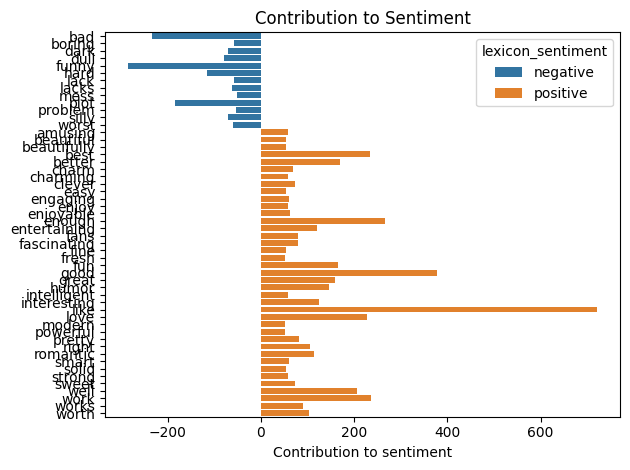

In [390]:
top_words = (
    coded.dropna(subset=["lexicon_sentiment"])
    .groupby(["lexicon_sentiment", "word"])
    .size()
    .reset_index(name="n")
    .query("n > 50")
    .assign(n_signed=lambda d: np.where(d["lexicon_sentiment"] == "negative", -d["n"], d["n"]))
)

sns.barplot(data=top_words, x="n_signed", y="word", hue="lexicon_sentiment", dodge=False)
plt.title("Contribution to Sentiment")
plt.xlabel("Contribution to sentiment")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [391]:
# Aggregate positive vs negative word counts
sent_counts = (
    coded.groupby("review_id")["lexicon_sentiment"]
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)

# Determine predicted sentiment
sent_counts["predicted"] = np.where(
    sent_counts["positive"] > sent_counts["negative"], "positive", "negative"
)

# Attach gold-standard human label
sent_counts["human"] = movie_reviews["polarity"]

In [392]:
sent_counts

lexicon_sentiment,review_id,negative,positive,predicted,human
0,2,0,1,positive,positive
1,3,0,1,positive,positive
2,4,0,3,positive,positive
3,5,1,3,positive,positive
4,6,1,2,positive,positive
...,...,...,...,...,...
9370,10657,2,2,negative,negative
9371,10658,1,0,negative,negative
9372,10660,4,0,negative,negative
9373,10661,0,1,positive,negative


In [393]:
precision = precision_score(sent_counts["human"], sent_counts["predicted"], pos_label="positive")
recall = recall_score(sent_counts["human"], sent_counts["predicted"], pos_label="positive")

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(confusion_matrix(sent_counts["human"], sent_counts["predicted"], labels=["positive", "negative"]))

Precision: 0.722
Recall:    0.594
[[3167 2164]
 [1222 2822]]


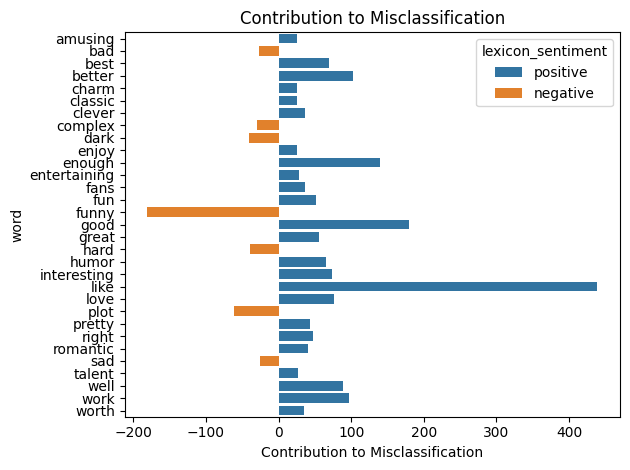

In [394]:
coded = coded.merge(sent_counts[["review_id", "predicted"]], on="review_id", how="left")

coded["misclassified"] = (
    (coded["lexicon_sentiment"] == "positive") & (coded["polarity"] == "negative")
) | (
    (coded["lexicon_sentiment"] == "negative") & (coded["polarity"] == "positive")
)

misclassified = (
    coded[coded["misclassified"] & coded["lexicon_sentiment"].notna()]
    .groupby(["word", "lexicon_sentiment"])
    .size()
    .reset_index(name="n")
    .query("n >= 25")
    .assign(n_signed=lambda d: np.where(d["lexicon_sentiment"] == "negative", -d["n"], d["n"]))
)

sns.barplot(data=misclassified, x="n_signed", y="word", hue="lexicon_sentiment", dodge=False)
plt.title("Contribution to Misclassification")
plt.xlabel("Contribution to Misclassification")
plt.tight_layout()
plt.show()

In [395]:
def precision_recall_f1(y_true, y_pred, positive_label="positive"):
    """
    Compute precision, recall, and F1 score manually.
    
    Parameters
    ----------
    y_true : list or array
        True labels
    y_pred : list or array
        Predicted labels
    positive_label : str or int
        The label considered as "positive"
        
    Returns
    -------
    precision, recall, f1 : floats
    """
    # Initialize counters
    TP = FP = FN = TN = 0
    
    for t, p in zip(y_true, y_pred):
        if p == positive_label and t == positive_label:
            TP += 1
        elif p == positive_label and t != positive_label:
            FP += 1
        elif p != positive_label and t == positive_label:
            FN += 1
        else:
            TN += 1
    
    # Calculate metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)
          if (precision + recall) > 0 else 0.0)
    
    return precision, recall, f1

In [396]:
y_true = ["positive", "positive", "negative", "negative", "positive"]
y_pred = ["positive", "negative", "negative", "positive", "positive"]

precision, recall, f1 = precision_recall_f1(y_true, y_pred)
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")

Precision: 0.667
Recall:    0.667
F1 Score:  0.667


In [397]:
precision_recall_f1(sent_counts["human"], sent_counts["predicted"])

(0.72157666894509, 0.5940724066779216, 0.6516460905349795)

In [398]:
sent_counts["correct"] = sent_counts["human"] == sent_counts["predicted"]
sent_counts["correct"].value_counts()

correct
True     5989
False    3386
Name: count, dtype: int64

In [399]:
sent_counts

lexicon_sentiment,review_id,negative,positive,predicted,human,correct
0,2,0,1,positive,positive,True
1,3,0,1,positive,positive,True
2,4,0,3,positive,positive,True
3,5,1,3,positive,positive,True
4,6,1,2,positive,positive,True
...,...,...,...,...,...,...
9370,10657,2,2,negative,negative,True
9371,10658,1,0,negative,negative,True
9372,10660,4,0,negative,negative,True
9373,10661,0,1,positive,negative,False


In [400]:
sent_counts.loc[sent_counts["correct"] == False, ].head()

lexicon_sentiment,review_id,negative,positive,predicted,human,correct
5,8,1,1,negative,positive,False
8,12,1,1,negative,positive,False
15,21,1,1,negative,positive,False
17,23,2,1,negative,positive,False
20,26,1,1,negative,positive,False


In [401]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Example mini-corpus
texts = [
    "good movie with excellent acting",
    "bad script and terrible pacing",
    "great film and wonderful direction",
    "awful plot but good soundtrack"
]

# Dictionary with weights
weighted_dict = {
    "good": 1, "excellent": 3, "great": 2,
    "bad": -1, "terrible": -3, "awful": -2,
    "wonderful": 3
}

def weighted_sentiment(text, dictionary):
    tokens = text.lower().split()
    weights = [dictionary.get(tok, 0) for tok in tokens]
    return sum(weights)

scores = [weighted_sentiment(t, weighted_dict) for t in texts]
pd.DataFrame({"text": texts, "weighted_score": scores})

,text,weighted_score
0,good movie with excellent acting,4
1,bad script and terrible pacing,-4
2,great film and wonderful direction,5
3,awful plot but good soundtrack,-1


In [402]:
import re

negations = {"not", "never", "no"}
intensifiers = {"very": 1.5, "extremely": 2.0, "slightly": 0.5}

def contextual_sentiment(text, dictionary):
    tokens = text.lower().split()
    score = 0
    for i, tok in enumerate(tokens):
        if tok in dictionary:
            base = dictionary[tok]
            # check for negation in previous 3 words
            window = tokens[max(0, i-3):i]
            if any(w in negations for w in window):
                base *= -1
            # check for intensifiers just before
            if i > 0 and tokens[i-1] in intensifiers:
                base *= intensifiers[tokens[i-1]]
            score += base
    return score

texts = [
    "very good movie",
    "not good movie",
    "slightly bad script",
    "extremely awful direction"
]

for t in texts:
    print(f"{t:25s} → {contextual_sentiment(t, weighted_dict):.2f}")

very good movie           → 1.50
not good movie            → -1.00
slightly bad script       → -0.50
extremely awful direction → -4.00


In [403]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pos_words = my_dict.loc[my_dict["lexicon_sentiment"] == "positive", "word"].tolist()
neg_words = my_dict.loc[my_dict["lexicon_sentiment"] == "negative", "word"].tolist()

def count_dict_hits(text, dictionary):
    tokens = text.lower().split()
    return sum(t in dictionary for t in tokens)

movie_reviews["pos_count"] = movie_reviews["value"].apply(lambda x: count_dict_hits(x, pos_words))
movie_reviews["neg_count"] = movie_reviews["value"].apply(lambda x: count_dict_hits(x, neg_words))
movie_reviews["total_count"] = movie_reviews["pos_count"] + movie_reviews["neg_count"]

X = movie_reviews[["pos_count", "neg_count", "total_count"]]
y = (movie_reviews["polarity"] == "positive").astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")
print("Model coefficients:", dict(zip(X.columns, model.coef_[0])))

Accuracy: 0.651
Model coefficients: {'pos_count': np.float64(0.491777578121234), 'neg_count': np.float64(-0.42546456270200406), 'total_count': np.float64(0.0663130154192221)}


# Negations and intensifiers

In [404]:
my_dict

,word,lexicon_sentiment
0,a+,positive
1,abound,positive
2,abounds,positive
3,abundance,positive
4,abundant,positive
...,...,...
6784,zaps,negative
6785,zealot,negative
6786,zealous,negative
6787,zealously,negative


In [405]:
# Convert to {word: numeric_score}
my_dict_new = {
    row["word"]: 1 if row["lexicon_sentiment"] == "positive" else -1
    for _, row in my_dict.iterrows()
}

In [406]:
list(my_dict_new.items())[:5]

[('a+', 1), ('abound', 1), ('abounds', 1), ('abundance', 1), ('abundant', 1)]

In [407]:
negations = {"not", "no", "never", "none", "hardly", "barely"}
intensifiers = {"very": 1.5, "extremely": 2.0, "really": 1.3, "super": 1.8}
downtoners = {"slightly": 0.5, "somewhat": 0.7, "barely": 0.4}

import re

def contextual_sentiment(text, dictionary):
    """Compute sentiment with negation and intensifier handling."""
    tokens = re.findall(r"\b\w+\b", text.lower())
    score = 0
    for i, tok in enumerate(tokens):
        if tok in dictionary:
            val = dictionary[tok]
            window = tokens[max(0, i-3):i]
            # Negation flips sign
            if any(w in negations for w in window):
                val *= -1
            # Intensifiers / downtoners just before
            if i > 0:
                prev = tokens[i-1]
                if prev in intensifiers:
                    val *= intensifiers[prev]
                elif prev in downtoners:
                    val *= downtoners[prev]
            score += val
    return score

In [408]:
# Apply to the review dataset
movie_reviews["score_contextual"] = movie_reviews["value"].apply(
    lambda x: contextual_sentiment(str(x), my_dict_new)
)

# Predicted labels
movie_reviews["predicted_contextual"] = np.where(
    movie_reviews["score_contextual"] > 0, "positive", "negative"
)

In [409]:
def baseline_sentiment(text, dictionary):
    tokens = re.findall(r"\b\w+\b", str(text).lower())
    return sum(dictionary.get(t, 0) for t in tokens)

movie_reviews["score_baseline"] = movie_reviews["value"].apply(
    lambda x: baseline_sentiment(x, my_dict_new)
)

movie_reviews["predicted_baseline"] = np.where(
    movie_reviews["score_baseline"] > 0, "positive", "negative"
)

In [410]:
precision, recall, f1_base = precision_recall_f1(
    movie_reviews["polarity"], movie_reviews["predicted_baseline"]
)
precision_c, recall_c, f1_context = precision_recall_f1(
    movie_reviews["polarity"], movie_reviews["predicted_contextual"]
)

print("Baseline dictionary:")
print(f"  Precision={precision:.3f}, Recall={recall:.3f}, F1={f1_base:.3f}")

print("\nContextual dictionary (with negations/intensifiers):")
print(f"  Precision={precision_c:.3f}, Recall={recall_c:.3f}, F1={f1_context:.3f}")

Baseline dictionary:
  Precision=0.681, Recall=0.571, F1=0.621

Contextual dictionary (with negations/intensifiers):
  Precision=0.684, Recall=0.570, F1=0.622


# Dictionary expansion with word vectors

In [411]:
import spacy
from pprint import pprint

# Load spaCy's medium or large model (includes word vectors)
nlp = spacy.load("en_core_web_lg")  # or en_core_web_lg

# Example seed dictionary
# Define anchors for each side of the spectrum
seed_positive = ["good", "happy", "excellent", "love", "great"]
seed_negative = ["bad", "sad", "terrible", "hate", "awful"]

In [412]:
def expand_dictionary(seed_words, topn=10, similarity_threshold=0.5):
    """
    Expand a seed dictionary using spaCy word vectors.

    Returns
    -------
    dict
        Mapping seed_word -> list of similar words
    """
    expansion = {}
    for word in seed_words:
        token = nlp(word)
        # Compare to all vocab entries with vectors
        similarities = []
        for candidate in nlp.vocab:
            if candidate.has_vector and candidate.is_lower and candidate.is_alpha and not candidate.is_stop:
                sim = token.similarity(candidate)
                if sim >= similarity_threshold and candidate.text != word:
                    similarities.append((candidate.text, sim))
        similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:topn]
        expansion[word] = [w for w, s in similarities]
    return expansion

In [413]:
expanded_pos = expand_dictionary(seed_positive, topn=8, similarity_threshold=0.7)
expanded_neg = expand_dictionary(seed_negative, topn=8, similarity_threshold=0.7)

print("positive expansion:")
print(expanded_pos)

print("\nnegative expansion:")
print(expanded_neg)

positive expansion:
{'good': [], 'happy': [], 'excellent': ['good'], 'love': [], 'great': ['good', 'excellent']}

negative expansion:
{'bad': ['good'], 'sad': [], 'terrible': ['bad'], 'hate': [], 'awful': ['terrible', 'bad']}


# Dictionary analysis with spaCy

In [414]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [415]:
list(my_dict_new.items())[:5]


negations = {"not", "no", "never", "none", "hardly", "barely"}


def spacy_dictionary_sentiment(doc, dictionary):
    score = 0
    for token in doc:
        lemma = token.lemma_.lower()
        if lemma in dictionary:
            val = dictionary[lemma]
            # Look up to 3 tokens before the current one for negations
            window = [w.lower_ for w in doc[max(0, token.i-3):token.i]]
            if any(w in negations for w in window):
                val *= -1
            score += val
    return score

In [416]:
movie_reviews

,value,polarity,review_id,tokens,pos_count,neg_count,total_count,score_contextual,predicted_contextual,score_baseline,predicted_baseline
0,"the rock is destined to be the 21st century's new "" conan "" and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .",positive,1,"[the, rock, is, destined, to, be, the, 21st, century, 's, new, ``, conan, ``, and, that, he, 's, going, to, make, a, splash, even, greater, than, arnold, schwarzenegger, ,, jean-claud, van, damme, or, steven, segal, .]",0,0,0,0.0,negative,0,negative
1,"the gorgeously elaborate continuation of "" the lord of the rings "" trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .",positive,2,"[the, gorgeously, elaborate, continuation, of, ``, the, lord, of, the, rings, ``, trilogy, is, so, huge, that, a, column, of, words, can, not, adequately, describe, co-writer/director, peter, jackson, 's, expanded, vision, of, j, ., r, ., r, ., tolkien, 's, middle-earth, .]",1,0,1,1.0,positive,1,positive
2,effective but too-tepid biopic,positive,3,"[effective, but, too-tepid, biopic]",1,0,1,0.0,negative,0,negative
3,"if you sometimes like to go to the movies to have fun , wasabi is a good place to start .",positive,4,"[if, you, sometimes, like, to, go, to, the, movies, to, have, fun, ,, wasabi, is, a, good, place, to, start, .]",3,0,3,3.0,positive,3,positive
4,"emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .",positive,5,"[emerges, as, something, rare, ,, an, issue, movie, that, 's, so, honest, and, keenly, observed, that, it, does, n't, feel, like, one, .]",3,1,4,2.0,positive,2,positive
...,...,...,...,...,...,...,...,...,...,...,...
10657,a terrible movie that some people will nevertheless find moving .,negative,10658,"[a, terrible, movie, that, some, people, will, nevertheless, find, moving, .]",0,1,1,-1.0,negative,-1,negative
10658,there are many definitions of 'time waster' but this movie must surely be one of them .,negative,10659,"[there, are, many, definitions, of, 'time, waster, ', but, this, movie, must, surely, be, one, of, them, .]",0,0,0,0.0,negative,0,negative
10659,"as it stands , crocodile hunter has the hurried , badly cobbled look of the 1959 godzilla , which combined scenes of a japanese monster flick with canned shots of raymond burr commenting on the monster's path of destruction .",negative,10660,"[as, it, stands, ,, crocodile, hunter, has, the, hurried, ,, badly, cobbled, look, of, the, 1959, godzilla, ,, which, combined, scenes, of, a, japanese, monster, flick, with, canned, shots, of, raymond, burr, commenting, on, the, monster, 's, path, of, destruction, .]",0,3,3,-4.0,negative,-4,negative
10660,the thing looks like a made-for-home-video quickie .,negative,10661,"[the, thing, looks, like, a, made-for-home-video, quickie, .]",1,0,1,1.0,positive,1,positive


In [417]:
texts = movie_reviews["value"].astype(str).tolist()

scores = []
for doc in tqdm(nlp.pipe(texts, batch_size=64, n_process=2), total=len(texts)):
    scores.append(spacy_dictionary_sentiment(doc, my_dict_new))

movie_reviews["spacy_score"] = scores
movie_reviews.head()

100%|██████████| 10662/10662 [00:16<00:00, 652.08it/s] 


,value,polarity,review_id,tokens,pos_count,neg_count,total_count,score_contextual,predicted_contextual,score_baseline,predicted_baseline,spacy_score
0,"the rock is destined to be the 21st century's new "" conan "" and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .",positive,1,"[the, rock, is, destined, to, be, the, 21st, century, 's, new, ``, conan, ``, and, that, he, 's, going, to, make, a, splash, even, greater, than, arnold, schwarzenegger, ,, jean-claud, van, damme, or, steven, segal, .]",0,0,0,0.0,negative,0,negative,1
1,"the gorgeously elaborate continuation of "" the lord of the rings "" trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .",positive,2,"[the, gorgeously, elaborate, continuation, of, ``, the, lord, of, the, rings, ``, trilogy, is, so, huge, that, a, column, of, words, can, not, adequately, describe, co-writer/director, peter, jackson, 's, expanded, vision, of, j, ., r, ., r, ., tolkien, 's, middle-earth, .]",1,0,1,1.0,positive,1,positive,1
2,effective but too-tepid biopic,positive,3,"[effective, but, too-tepid, biopic]",1,0,1,0.0,negative,0,negative,0
3,"if you sometimes like to go to the movies to have fun , wasabi is a good place to start .",positive,4,"[if, you, sometimes, like, to, go, to, the, movies, to, have, fun, ,, wasabi, is, a, good, place, to, start, .]",3,0,3,3.0,positive,3,positive,3
4,"emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .",positive,5,"[emerges, as, something, rare, ,, an, issue, movie, that, 's, so, honest, and, keenly, observed, that, it, does, n't, feel, like, one, .]",3,1,4,2.0,positive,2,positive,2


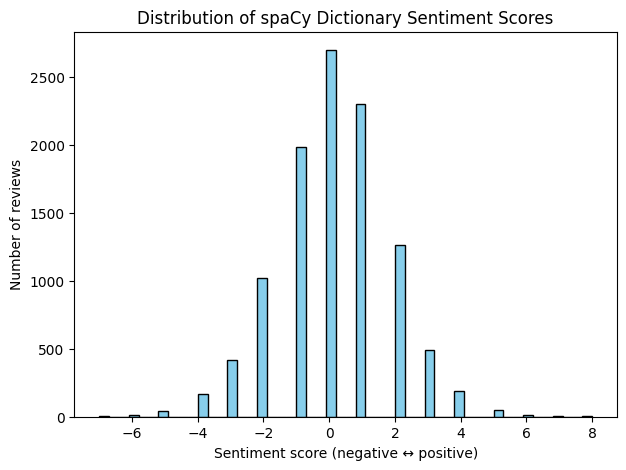

In [418]:
plt.figure(figsize=(7,5))
plt.hist(movie_reviews["spacy_score"], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of spaCy Dictionary Sentiment Scores")
plt.xlabel("Sentiment score (negative ↔ positive)")
plt.ylabel("Number of reviews")
plt.show()

In [419]:
movie_reviews["predicted_spacy"] = np.where(movie_reviews["spacy_score"] > 0, "positive", "negative")

In [420]:
precision, recall, f1 = precision_recall_f1(movie_reviews["polarity"], movie_reviews["predicted_spacy"])
print(f"spaCy dictionary model — Precision: {precision:.3f}, Recall: {recall:.3f}, F₁: {f1:.3f}")

spaCy dictionary model — Precision: 0.690, Recall: 0.559, F₁: 0.618


In [421]:
errors = movie_reviews[movie_reviews["polarity"] != movie_reviews["predicted_spacy"]]
errors.sample(5)[["value", "polarity", "spacy_score", "predicted_spacy"]]

,value,polarity,spacy_score,predicted_spacy
1176,if your taste runs to 'difficult' films you absolutely can't miss it .,positive,-2,negative
5644,just because a walk to remember is shrewd enough to activate girlish tear ducts doesn't mean it's good enough for our girls .,negative,3,positive
1071,a rarity among recent iranian films : it's a comedy full of gentle humor that chides the absurdity of its protagonist's plight .,positive,-1,negative
1998,"the film delivers what it promises : a look at the "" wild ride "" that ensues when brash young men set out to conquer the online world with laptops , cell phones and sketchy business plans .",positive,-2,negative
2347,"a powerful and telling story that examines forbidden love , racial tension , and other issues that are as valid today as they were in the 1950s .",positive,-1,negative


In [422]:
def extract_matched_words(doc, dictionary):
    return [t.lemma_.lower() for t in doc if t.lemma_.lower() in dictionary]

movie_reviews["matched_words"] = [
    extract_matched_words(doc, my_dict_new) for doc in nlp.pipe(texts, batch_size=64)
]

movie_reviews[["value", "matched_words", "spacy_score"]].head()

,value,matched_words,spacy_score
0,"the rock is destined to be the 21st century's new "" conan "" and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .",[great],1
1,"the gorgeously elaborate continuation of "" the lord of the rings "" trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .",[gorgeously],1
2,effective but too-tepid biopic,"[effective, tepid]",0
3,"if you sometimes like to go to the movies to have fun , wasabi is a good place to start .","[like, fun, good]",3
4,"emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .","[issue, honest, keenly, like]",2


In [423]:
missclassified = errors["value"].astype(str).tolist()


errors["matched_words"] = [extract_matched_words(doc, my_dict_new) for doc in nlp.pipe(missclassified, batch_size=64)]


/var/folders/4w/d1wyhk3s065b_v2c59mxyd6r0000gn/T/ipykernel_49150/3890891691.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors["matched_words"] = [extract_matched_words(doc, my_dict_new) for doc in nlp.pipe(missclassified, batch_size=64)]


In [424]:
errors[["value", "matched_words", "polarity", "spacy_score"]].tail()

,value,matched_words,polarity,spacy_score
10642,"you come away thinking not only that kate isn't very bright , but that she hasn't been worth caring about and that maybe she , janine and molly -- an all-woman dysfunctional family -- deserve one another .","[bright, worth]",negative,2
10650,"for this sort of thing to work , we need agile performers , but the proficient , dull sorvino has no light touch , and rodan is out of his league .","[work, agile, proficient, dull]",negative,2
10654,it's tough to be startled when you're almost dozing .,[tough],negative,1
10660,the thing looks like a made-for-home-video quickie .,[like],negative,1
10661,"enigma is well-made , but it's just too dry and too placid .",[well],negative,1


In [425]:
def extract_matched_words_values(doc, dictionary):

    matches = []
    for token in doc:
        lemma = token.lemma_.lower()
        if lemma in dictionary:
            matches.append((lemma, dictionary[lemma]))
    return matches

errors["matched_words_values"] = [extract_matched_words_values(doc, my_dict_new) for doc in nlp.pipe(missclassified, batch_size=64)]

errors[["value", "matched_words_values", "polarity", "spacy_score"]].tail()


/var/folders/4w/d1wyhk3s065b_v2c59mxyd6r0000gn/T/ipykernel_49150/1604528085.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors["matched_words_values"] = [extract_matched_words_values(doc, my_dict_new) for doc in nlp.pipe(missclassified, batch_size=64)]


,value,matched_words_values,polarity,spacy_score
10642,"you come away thinking not only that kate isn't very bright , but that she hasn't been worth caring about and that maybe she , janine and molly -- an all-woman dysfunctional family -- deserve one another .","[(bright, 1), (worth, 1)]",negative,2
10650,"for this sort of thing to work , we need agile performers , but the proficient , dull sorvino has no light touch , and rodan is out of his league .","[(work, 1), (agile, 1), (proficient, 1), (dull, -1)]",negative,2
10654,it's tough to be startled when you're almost dozing .,"[(tough, 1)]",negative,1
10660,the thing looks like a made-for-home-video quickie .,"[(like, 1)]",negative,1
10661,"enigma is well-made , but it's just too dry and too placid .","[(well, 1)]",negative,1


In [426]:
pd.set_option("display.max_colwidth", None)

errors[["value", "matched_words_values", "polarity", "spacy_score"]].tail()

,value,matched_words_values,polarity,spacy_score
10642,"you come away thinking not only that kate isn't very bright , but that she hasn't been worth caring about and that maybe she , janine and molly -- an all-woman dysfunctional family -- deserve one another .","[(bright, 1), (worth, 1)]",negative,2
10650,"for this sort of thing to work , we need agile performers , but the proficient , dull sorvino has no light touch , and rodan is out of his league .","[(work, 1), (agile, 1), (proficient, 1), (dull, -1)]",negative,2
10654,it's tough to be startled when you're almost dozing .,"[(tough, 1)]",negative,1
10660,the thing looks like a made-for-home-video quickie .,"[(like, 1)]",negative,1
10661,"enigma is well-made , but it's just too dry and too placid .","[(well, 1)]",negative,1
